<a href="https://colab.research.google.com/github/narendersurabhi/tradingLibrary/blob/main/Technical_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automating Stock Investing Technical Analysis With Python
### Using Python To Find When To Buy And Sell Stocks

In [ ]:
# ! pip install ta
# ! pip install yfinance

In [1]:
from ta.momentum import RSIIndicator
from ta.trend import MACD

import numpy as np
import pandas
from ta.volatility import BollingerBands

class Company:
    def __init__(self, symbol):
        self.symbol = symbol
        self.technical_indicators = None
        self.prices = None


def generate_buy_sell_signals(condition_buy, condition_sell, dataframe, strategy):
    last_signal = None
    indicators = []
    buy = []
    sell = []
    for i in range(0, len(dataframe)):
        # if buy condition is true and last signal was not Buy
        if condition_buy(i, dataframe) and last_signal != 'Buy':
            last_signal = 'Buy'
            indicators.append(last_signal)
            buy.append(dataframe['Close'].iloc[i])
            sell.append(np.nan)
        # if sell condition is true and last signal was Buy
        elif condition_sell(i, dataframe)  and last_signal == 'Buy':
            last_signal = 'Sell'
            indicators.append(last_signal)
            buy.append(np.nan)
            sell.append(dataframe['Close'].iloc[i])
        else:
            indicators.append(last_signal)
            buy.append(np.nan)
            sell.append(np.nan)

    dataframe[f'{strategy}_Last_Signal'] = np.array(last_signal)
    dataframe[f'{strategy}_Indicator'] = np.array(indicators)
    dataframe[f'{strategy}_Buy'] = np.array(buy)
    dataframe[f'{strategy}_Sell'] = np.array(sell)



def set_technical_indicators(config, company):
    company.technical_indicators = pandas.DataFrame()
    company.technical_indicators['Close'] = company.prices

    get_macd(config, company)
    get_rsi(config, company)
    get_bollinger_bands(config, company)


def get_macd(config, company):
    close_prices = company.prices
    dataframe = company.technical_indicators
    window_slow = 26
    signal = 9
    window_fast = 12
    macd = MACD(company.prices, window_slow, window_fast, signal)
    dataframe['MACD'] = macd.macd()
    dataframe['MACD_Histogram'] = macd.macd_diff()
    dataframe['MACD_Signal'] = macd.macd_signal()

    generate_buy_sell_signals(
        lambda x, dataframe: dataframe['MACD'].values[x] < dataframe['MACD_Signal'].iloc[x],
        lambda x, dataframe: dataframe['MACD'].values[x] > dataframe['MACD_Signal'].iloc[x],
        dataframe,
        'MACD')
    return dataframe


def get_rsi(config, company):
    close_prices = company.prices
    dataframe = company.technical_indicators
    rsi_time_period = 20

    rsi_indicator = RSIIndicator(close_prices, rsi_time_period)
    dataframe['RSI'] = rsi_indicator.rsi()

    low_rsi = 40
    high_rsi = 70

    generate_buy_sell_signals(
        lambda x, dataframe: dataframe['RSI'].values[x] < low_rsi,
        lambda x, dataframe: dataframe['RSI'].values[x] > high_rsi,
    dataframe, 'RSI')

    return dataframe


def get_bollinger_bands(config, company):

    close_prices = company.prices
    dataframe = company.technical_indicators

    window = 20

    indicator_bb = BollingerBands(close=close_prices, window=window, window_dev=2)

    # Add Bollinger Bands features
    dataframe['Bollinger_Bands_Middle'] = indicator_bb.bollinger_mavg()
    dataframe['Bollinger_Bands_Upper'] = indicator_bb.bollinger_hband()
    dataframe['Bollinger_Bands_Lower'] = indicator_bb.bollinger_lband()


    generate_buy_sell_signals(
        lambda x, signal: signal['Close'].values[x] < signal['Bollinger_Bands_Lower'].values[x],
        lambda x, signal: signal['Close'].values[x] > signal['Bollinger_Bands_Upper'].values[x],
        dataframe, 'Bollinger_Bands')

    return dataframe

In [3]:
import os

from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np


class TechnicalIndicatorsChartPlotter:
    def plot_price_and_signals(self, fig, company, data, strategy, axs):
        last_signal_val = data[f'{strategy}_Last_Signal'].values[-1]
        last_signal = 'Unknown' if not last_signal_val else last_signal_val
        title = f'Close Price Buy/Sell Signals using {strategy}.  Last Signal: {last_signal}'
        fig.suptitle(f'Top: {company.symbol} Stock Price. Bottom: {strategy}')

        if not data[f'{strategy}_Buy'].isnull().all():
            axs[0].scatter(data.index, data[f'{strategy}_Buy'], color='green', label='Buy Signal', marker='^', alpha=1)
        if not data[f'{strategy}_Sell'].isnull().all():
            axs[0].scatter(data.index, data[f'{strategy}_Sell'], color='red', label='Sell Signal', marker='v', alpha=1)
        axs[0].plot(company.prices, label='Close Price', color='blue', alpha=0.35)

        plt.xticks(rotation=45)
        axs[0].set_title(title)
        axs[0].set_xlabel('Date', fontsize=18)
        axs[0].set_ylabel('Close Price', fontsize=18)
        axs[0].legend(loc='upper left')
        axs[0].grid()

    def plot_macd(self, company):
        image = f'images/{company.symbol}_macd.png'
        macd = company.technical_indicators

        # Create and plot the graph
        fig, axs = plt.subplots(2, sharex=True, figsize=(13,9))
        self.plot_price_and_signals(fig, company, macd, 'MACD', axs)

        axs[1].plot(macd['MACD'], label=company.symbol+' MACD', color = 'green')
        axs[1].plot(macd['MACD_Signal'], label='Signal Line', color='orange')
        positive = macd['MACD_Histogram'][(macd['MACD_Histogram'] >= 0)]
        negative = macd['MACD_Histogram'][(macd['MACD_Histogram'] < 0)]
        axs[1].bar(positive.index, positive, color='green')
        axs[1].bar(negative.index, negative, color='red')    
        axs[1].legend(loc='upper left')
        axs[1].grid()
        print(os.path.abspath(image))
        plt.show()

    def plot_rsi(self, company):
        image = f'images/{company.symbol}_rsi.png'
        rsi = company.technical_indicators
        low_rsi = 40
        high_rsi = 70

        #plt.style.use('default')
        fig, axs = plt.subplots(2, sharex=True, figsize=(13, 9))
        self.plot_price_and_signals(fig, company, rsi, 'RSI', axs)
        axs[1].fill_between(rsi.index, y1=low_rsi, y2=high_rsi, color='#adccff', alpha=0.3)
        axs[1].plot(rsi['RSI'], label='RSI', color='blue', alpha=0.35)
        axs[1].legend(loc='upper left')
        axs[1].grid()
        plt.show()

    def plot_bollinger_bands(self, company):
        image = f'images/{company.symbol}_bb.png'
        bollinger_bands = company.technical_indicators

        fig, axs = plt.subplots(2, sharex=True, figsize=(13, 9))

        self.plot_price_and_signals(fig, company, bollinger_bands, 'Bollinger_Bands', axs)

        axs[1].plot(bollinger_bands['Bollinger_Bands_Middle'], label='Middle', color='blue', alpha=0.35)
        axs[1].plot(bollinger_bands['Bollinger_Bands_Upper'], label='Upper', color='green', alpha=0.35)
        axs[1].plot(bollinger_bands['Bollinger_Bands_Lower'], label='Lower', color='red', alpha=0.35)
        axs[1].fill_between(bollinger_bands.index, bollinger_bands['Bollinger_Bands_Lower'], bollinger_bands['Bollinger_Bands_Upper'], alpha=0.1)
        axs[1].legend(loc='upper left')
        axs[1].grid()

        plt.show()

In [5]:
from unittest import TestCase

# from technical_indicators_calculator import set_technical_indicators, Company
# from technical_indicators_chart_plotting import TechnicalIndicatorsChartPlotter
import yfinance as yf

class TestTechnicalIndicator(TestCase):

    def test_tech_indicator(self):
        company = Company('TWTR')
        config = {}
        company.prices = yf.Ticker(company.symbol).history(period='1y')['Close']
        set_technical_indicators(config, company)

        tacp = TechnicalIndicatorsChartPlotter()
        tacp.plot_macd(company)
        tacp.plot_rsi(company)
        tacp.plot_bollinger_bands(company)

/Users/narendersurabhi/Documents/github_new/tradingLibrary/images/TWTR_macd.png


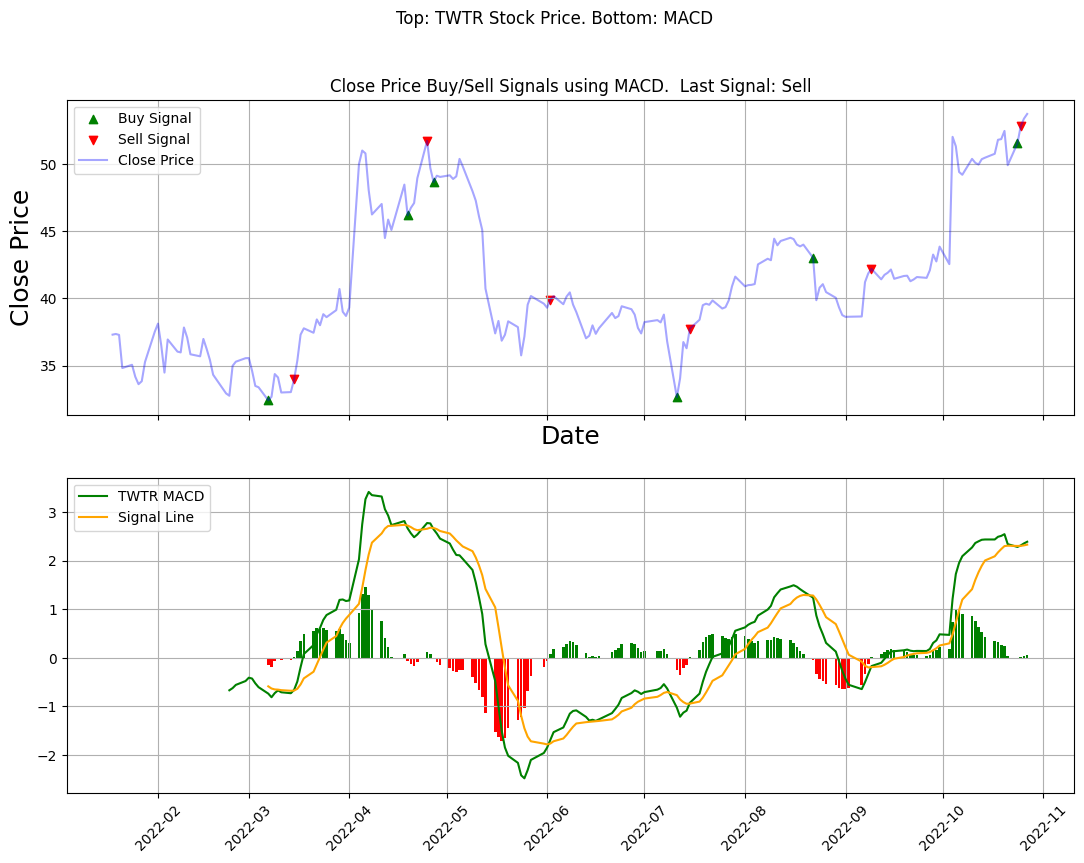

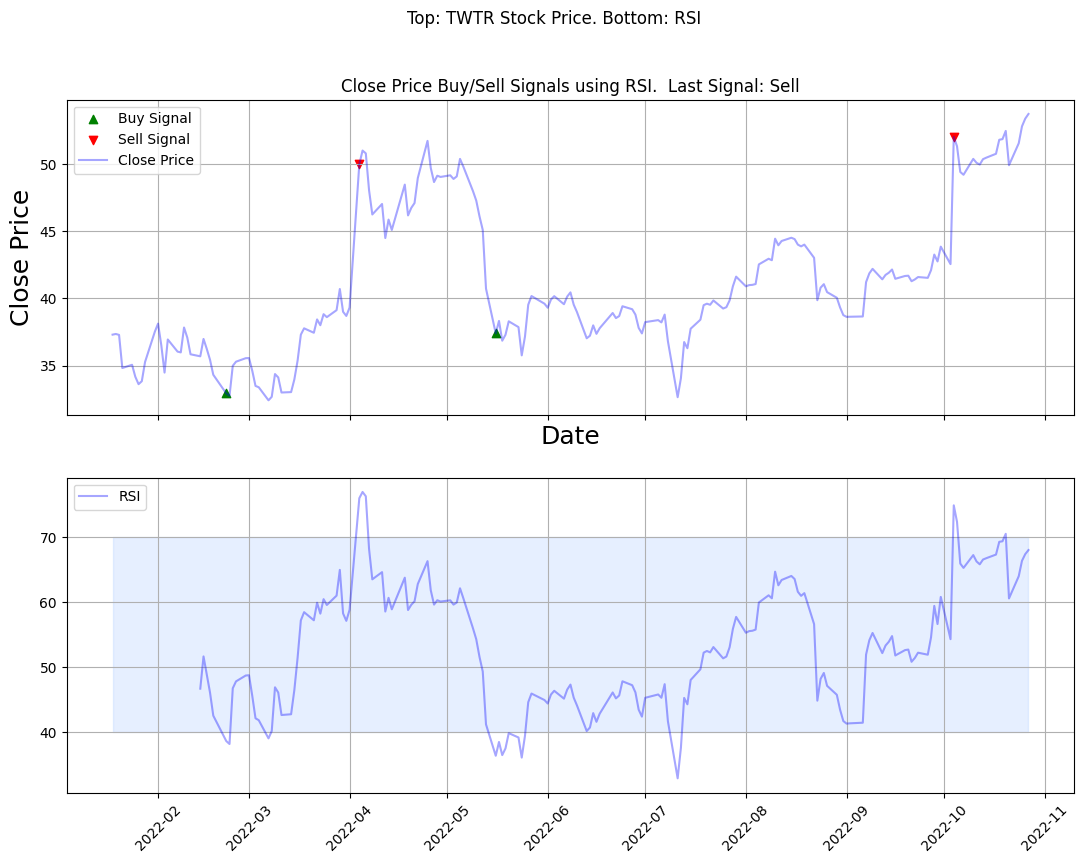

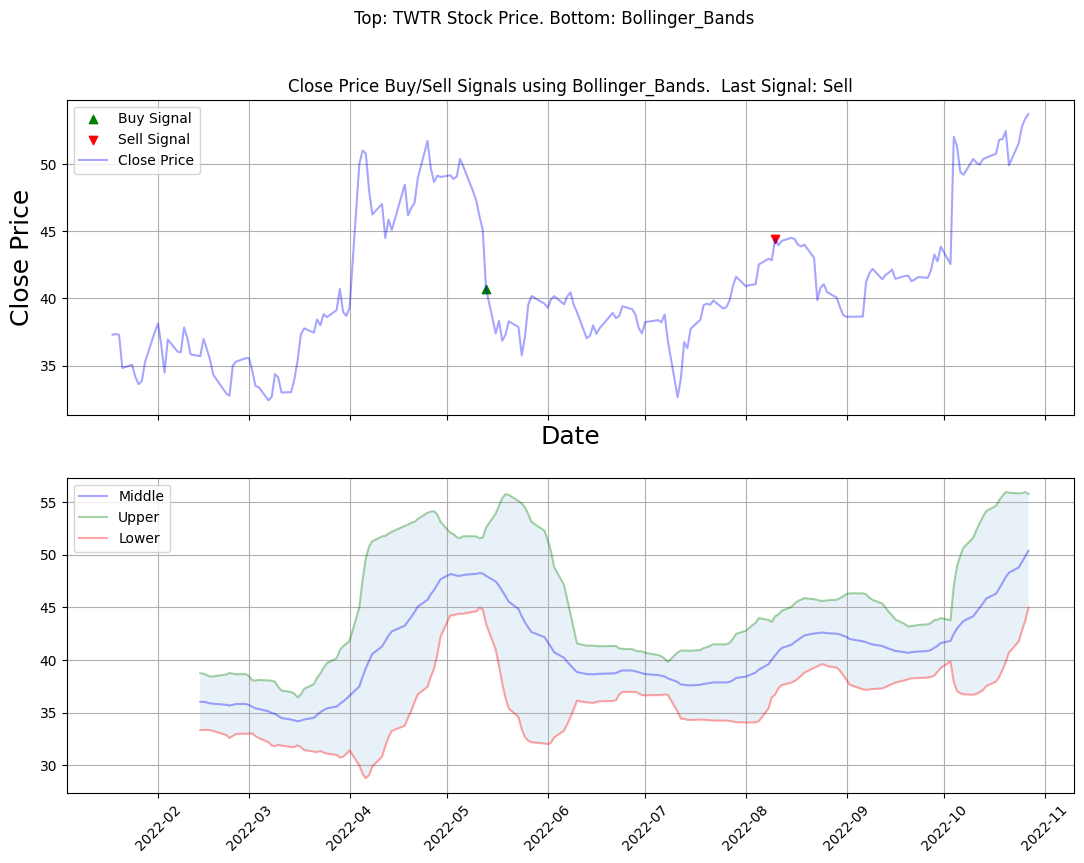

In [6]:
company = Company('TWTR')
config = {}
company.prices = yf.Ticker(company.symbol).history(period='1y')['Close']
set_technical_indicators(config, company)

tacp = TechnicalIndicatorsChartPlotter()
tacp.plot_macd(company)
tacp.plot_rsi(company)
tacp.plot_bollinger_bands(company)

In [7]:
from ta import add_all_ta_features

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
    
# add_all_ta_features()
def get_stock_ohlcv(ticker, interval='1d', period='1y'):
    df = yf.Ticker(symbol).history(period=period, interval=interval)
    return df


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-18 00:00:00-05:00,37.720001,38.200001,37.130001,37.299999,14915247,0.0,0.0
2022-01-19 00:00:00-05:00,37.130001,38.279999,37.005001,37.349998,19797988,0.0,0.0
2022-01-20 00:00:00-05:00,37.840000,39.029999,37.195000,37.279999,17688913,0.0,0.0
2022-01-21 00:00:00-05:00,36.900002,37.080002,34.794998,34.820000,25674078,0.0,0.0
2022-01-24 00:00:00-05:00,33.700001,35.139999,32.049999,35.060001,31932961,0.0,0.0
...,...,...,...,...,...,...,...
2022-10-21 00:00:00-04:00,50.000000,50.750000,49.549999,49.889999,51209029,0.0,0.0
2022-10-24 00:00:00-04:00,50.709999,51.860001,50.520000,51.520000,22987553,0.0,0.0
2022-10-25 00:00:00-04:00,52.415001,53.180000,52.200001,52.779999,35077848,0.0,0.0


In [1]:
import stockdata as sd

In [27]:
import yfinance as yf
import pandas as pd
import numpy as np

def getOHLCV(ticker, interval='1d', period='1y', start=None, end=None):
    """
        :Parameters:
            period : str
                Valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
                Either Use period parameter or use start and end
            interval : str
                Valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
                Intraday data cannot extend last 60 days
            start: str
                Download start date string (YYYY-MM-DD) or _datetime.
                Default is 1900-01-01
            end: str
                Download end date string (YYYY-MM-DD) or _datetime.
                Default is now		
    """
    df = yf.Ticker(ticker).history(period=period, interval=interval, start=start, end=end)
    df.index = df.index.to_period('D')
    return df

In [2]:
sd.getOHLCV("AAPL")

/Users/narendersurabhi/Documents/github_new/tradingLibrary/stockdata.py:22: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.index = df.index.to_period('D')


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-01-18,170.520330,171.544385,168.432457,168.820206,90956700,0.0,0.0
2022-01-19,169.019064,170.092834,164.982493,165.270813,94815000,0.0,0.0
2022-01-20,166.016463,168.700880,163.232617,163.560715,91420500,0.0,0.0
2022-01-21,163.471235,165.370218,161.363473,161.472839,122848900,0.0,0.0
2022-01-24,159.096650,161.363493,153.807340,160.687408,162294600,0.0,0.0
...,...,...,...,...,...,...,...
2023-01-11,131.250000,133.509995,130.460007,133.490005,69458900,0.0,0.0
2023-01-12,133.880005,134.259995,131.440002,133.410004,71379600,0.0,0.0
2023-01-13,132.029999,134.919998,131.660004,134.759995,57758000,0.0,0.0


In [12]:
df_ind = add_all_ta_features(df, open = 'Open', high = 'High', low = 'Low', close = 'Close', volume = 'Volume')

/Users/narendersurabhi/opt/anaconda3/envs/working/lib/python3.8/site-packages/ta/trend.py:730: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  self._trs[0] = diff_directional_movement.dropna()[
/Users/narendersurabhi/opt/anaconda3/envs/working/lib/python3.8/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in scalar divide
  dip[idx] = 100 * (self._dip[idx] / value)
/Users/narendersurabhi/opt/anaconda3/envs/working/lib/python3.8/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in scalar divide
  din[idx] = 100 * (self._din[idx] / value)


In [17]:
df_ind.columns.to_list()

['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Dividends',
 'Stock Splits',
 'volume_adi',
 'volume_obv',
 'volume_cmf',
 'volume_fi',
 'volume_em',
 'volume_sma_em',
 'volume_vpt',
 'volume_vwap',
 'volume_mfi',
 'volume_nvi',
 'volatility_bbm',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_bbw',
 'volatility_bbp',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_kchi',
 'volatility_kcli',
 'volatility_dcl',
 'volatility_dch',
 'volatility_dcm',
 'volatility_dcw',
 'volatility_dcp',
 'volatility_atr',
 'volatility_ui',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_sma_fast',
 'trend_sma_slow',
 'trend_ema_fast',
 'trend_ema_slow',
 'trend_vortex_ind_pos',
 'trend_vortex_ind_neg',
 'trend_vortex_ind_diff',
 'trend_trix',
 'trend_mass_index',
 'trend_dpo',
 'trend_kst',
 'trend_kst_sig',
 'trend_kst_diff',
 'trend_ichimoku_conv',
 'trend_ichimoku_base',
 'trend_ic